In [14]:
import pandas as pd
import numpy as np
import json

In [15]:
import os

# process data in dms_simulator/exp-x folders
dir = '../dms_simulator'
output_dir = 'results/dmsconfig'

for i in range(9):
    prnt_path = '%s/exp-%d' % (dir, i)
    ddpg_exp = [f for f in os.listdir(prnt_path) if 'ddpg-exp' in f]
    for exp in ddpg_exp:
        with open('%s/%s' % (prnt_path, exp)) as f:
            lines = f.readlines()
        new_lines = [l.replace('[', '').replace(']', '').replace('\n', '') for l in lines]
        with open('%s/%s' % (output_dir, exp), 'w') as f:
            for l in new_lines:
                f.write('%s\n' % l)


In [16]:
algs = ['results/hyperopt', 'results/optuna', 'results/smac', 'results/dmsconfig']
exps = ['exp-%d' % i for i in range(9)]
lat_bounds = [x for x in list(range(0, 12, 2))]
# lat_bounds = [0]
lat_bounds.append(1)
lat_bounds.sort()

config_meta = '../meta/config_meta.csv'
cf_meta = pd.read_csv(config_meta)

# assign config array to dict
def load_config(cf_list):
    rlt = {}
    for i, cf in enumerate(cf_meta['name']):
        rlt.update({cf: int((cf_list[i] * (cf_meta['max'].iloc[i] - cf_meta['min'].iloc[i]) + cf_meta['min'].iloc[i]) * cf_meta['unit'].iloc[i])})
    return rlt


In [17]:
# find the best throughput and configurations that satisfy latency constraint
results = []
for alg in algs:
    for exp in exps:
        for lb in lat_bounds:
            if alg in ['results/hyperopt', 'results/optuna']:  # hyperopt & optuna
                test_id = '%s/progress_%s_%s.csv' % (alg, exp, str(lb))
                df = pd.read_csv(test_id)
                lt_bd = df['latency_bound'][0]
                df = df[df['latency'] < lt_bd]
                if df.shape[0] > 0:
                    row = df[df['latency'] <= df['latency_bound']]
                    row = df[df['throughput'] == df['throughput'].max()].iloc[0]
                    best_config = row['current_config'].replace('[', '').replace(']', '').split(' ')
                    best_config = np.array([float(x.strip()) for x in best_config if len(x) > 0])
                    best_config = load_config(best_config)
                    record = {
                        'alg': alg.split('/')[1],
                        'exp': exp,
                        'best_config': best_config,
                        'best_reward': row['best_reward'],
                        'throughput': row['throughput'],
                        'latency': row['latency'],
                        'latency_bound': row['latency_bound'],
                        'latency_bound_factor': lb
                    } 
                else:  # latency boundary can not be satisfied
                    record = {
                        'alg': alg.split('/')[1],
                        'exp': exp,
                        'best_config': best_config,
                        'best_reward': row['best_reward'],
                        'throughput': row['throughput'],
                        'latency': row['latency'],
                        'latency_bound': row['latency_bound'],
                        'latency_bound_factor': lb
                    }
            elif alg == 'results/smac':  # smac
                test_id = '%s/best_%s_%s.json' % (alg, exp, str(lb))
                with open(test_id) as f:
                    record = json.load(f)
                if record['latency'] > record['latency_bound']:
                    record['best_config'] = None
                else:
                    for i, cf in enumerate(cf_meta['name']):
                        k = cf.split('->')[1]
                        record['best_config'][cf] = int((record['best_config'][k] * (cf_meta['max'].iloc[i] - cf_meta['min'].iloc[i]) + cf_meta['min'].iloc[i]) * cf_meta['unit'].iloc[i])
                        del record['best_config'][k]
                record.update({
                    'alg': alg.split('/')[1],
                    'exp': exp,
                    'latency_bound_factor': lb
                })
                record['best_reward'] = -record['best_reward']
            else:  # ddpg
                test_id = '%s/ddpg-%s-%s.csv' % (alg, exp, str(lb))
                df = pd.read_csv(test_id)
                lt_bd = df['latency_bound'][0]
                df = df[df['latency'] < lt_bd]
                if df.shape[0] > 0:
                    row = df[df['throughput'] == df['throughput'].max()].iloc[0]
                    best_config = row['best_config'].replace('[', '').replace(']', '').split(' ')
                    best_config = np.array([float(x.strip()) for x in best_config if len(x) > 0])
                    best_config = load_config(best_config)
                    record = {
                        'alg': alg.split('/')[1],
                        'exp': exp,
                        'best_config': best_config,
                        'best_reward': row['best_reward'],
                        'throughput': row['throughput'],
                        'latency': row['latency'],
                        'latency_bound': row['latency_bound'],
                        'latency_bound_factor': lb
                    } 
                else:  # latency boundary can not be satisfied
                    record = {
                        'alg': alg.split('/')[1],
                        'exp': exp,
                        'best_config': best_config,
                        'best_reward': row['best_reward'],
                        'throughput': row['throughput'],
                        'latency': row['latency'],
                        'latency_bound': row['latency_bound'],
                        'latency_bound_factor': lb
                    }
                results.append(record)


results = pd.DataFrame(results)
results.to_csv('summary.csv', index=None)

In [18]:
# # process summary.csv
# from matplotlib import pyplot as plt

# all_records = []

# for exp in exps:
#     x = np.arange(5)
#     plt.figure(figsize=(10,6))
#     for i, alg in enumerate(algs):
#         total_width, n = 1, 5
#         bar_width = total_width / n  #设置柱状图的宽度
#         # tick_label = [al.split('/')[1] for al in algs]
        
#         # x = x - (total_width - width) / 2

#         rlt = results[(results['exp'] == exp) & (results['alg'] == alg.split('/')[1])]
#         tick_label = rlt['latency_bound_factor'].tolist()

#         thrs = rlt['throughput'].tolist()

#         plt.bar(x+i*(bar_width), thrs, bar_width, label='alg=%s' % alg.split('/')[1])
#         plt.title(exp)


#     plt.legend()  #显示图例，即label
#     plt.xticks(x + 1.5 * bar_width,tick_label)  #显示x坐标轴的标签,即tick_label,调整位置，使其落在两个直方图中间位置    
#     plt.show()


In [19]:
# produce experiment schdule based on learned best configurations

config_meta = pd.read_csv('../meta/config_meta.csv')
compression = config_meta[config_meta['name'] == 'producer->compression.type']['options'].tolist()[0].split('/')
compression = np.array(compression)
for exp in exps:
    for lb in lat_bounds:
        sch_exp = results[(results['exp'] == exp) & (results['latency_bound_factor'] == lb)]
        sch = sch_exp['best_config'].tolist()
        sch = pd.DataFrame(sch)
        sch['producer->compression.type'] = compression[sch['producer->compression.type']]
        # sch['id'] = np.array(range(len(algs)))
        sch['id'] = np.array(range(1))
        sch.to_csv('validate/schedule-%s-%s.csv' % (exp, str(lb)), index=None)

In [20]:
# generate client_profile.json for validation tests
with open('../exp-station/schedule.json') as f: 
    plan = json.load(f)

for i, exp in enumerate(plan):    
    # generate client_profile.json
    with open('../exp-station/client_profile.json') as f:
        profile = json.load(f)

    tmp = {
        "throughput": -1,
        "record-size": exp['record_size'],
        "transaction-duration-ms": 0
    }
    profile['pubs'] = []
    for _ in range(exp['producer']):
        profile['pubs'].append(tmp)
    
    with open('validate/client_profile-exp-%d.json' % i, 'w') as f:
        json.dump(profile, f)

In [21]:
# parse validation results

path = 'validation_results'

# Process log file to obtain external state data
import os
import pandas as pd
import numpy as np
import json

perf = pd.DataFrame([])
base_path = 'validation_results'

# read default latency data
def_results = pd.read_csv('../exp/default/summary.csv')

for exp in exps:
    for lb in lat_bounds:
        log_path = '%s/%s-%s/logs' % (base_path, exp, str(lb))
        try:
            pub_logs = [x for x in os.listdir(log_path) if 'pub' in x]
            for p in pub_logs:
                instance = p.split('.')[0]
                with open('%s/%s' % (log_path, p)) as f:
                    lines = f.readlines()
                    latency = []
                    throughput = []
                    for l in lines:
                        if 'avg latency' in l:
                            try:
                                lat = float(l.split(',')[2].replace(' ms avg latency', ''))
                                # thr = float(l.split(',')[1].split(' ')[1])
                                thr = float(l.split(',')[1].split('(')[1].split(' MB/sec')[0])
                                latency.append(lat)
                                throughput.append(thr)
                            except:
                                print(l)
                                continue
                    try:
                        df = {
                            'alg': algs[int(instance.split('-')[2])].split('/')[1], 
                            'latency': np.percentile(latency, 90), 
                            'throughput': np.percentile(throughput, 90),
                            'exp': exp,
                            'latency_bound_factor': lb,
                            'latency_bound': int(def_results[def_results['exp'] == exp]['latency'].tolist()[0]/(lb+1e-5))}
                    except Exception as ex:
                        print(ex)
                        continue
                    perf = perf.append(df, ignore_index=True)
        except Exception as ex:
            print(ex)

# perf.to_csv('performance_summary.csv', index=None)
perf_summary = pd.DataFrame([])
store = {}
for index, row in perf.iterrows():
    sess = '%s-%s-%s' % (row['alg'], row['exp'], str(row['latency_bound_factor']))
    if sess not in store:
        store.update({sess: {
            'latency': [row['latency']], 
            'throughput': [row['throughput']],
            'alg': row['alg'],
            'exp': row['exp'],
            'latency_bound_factor': row['latency_bound_factor'],
            'latency_bound': row['latency_bound']}})
    else:
        store[sess]['latency'].append(row['latency'])
        store[sess]['throughput'].append(row['throughput'])

for sess in store:
    perf_summary = perf_summary.append({
        'alg': store[sess]['alg'],
        'exp': store[sess]['exp'],
        'latency_bound_factor': store[sess]['latency_bound_factor'],
        'latency_bound': store[sess]['latency_bound'],
        'latency': np.mean(store[sess]['latency']), 
        'throughput': np.sum(store[sess]['throughput'])}, ignore_index=True)

# add performance of default configuration
def_perf = pd.read_csv('../exp/default/summary.csv')
for lb in lat_bounds:
    for i, row in def_perf.iterrows():
        perf_summary = perf_summary.append({
        'alg': 'default',
        'exp': row['exp'],
        'latency_bound_factor': lb,
        'latency_bound': row['latency']/(lb+1e-5),
        'latency': row['latency'], 
        'throughput': int(row['throughput'])}, ignore_index=True)

perf_summary.to_csv('performance_summary.csv', index=None)

cannot do a non-empty take from an empty axes.


In [22]:
all_algs = algs
perf_summary = pd.read_csv('performance_summary.csv')
all_algs.append('results/default')

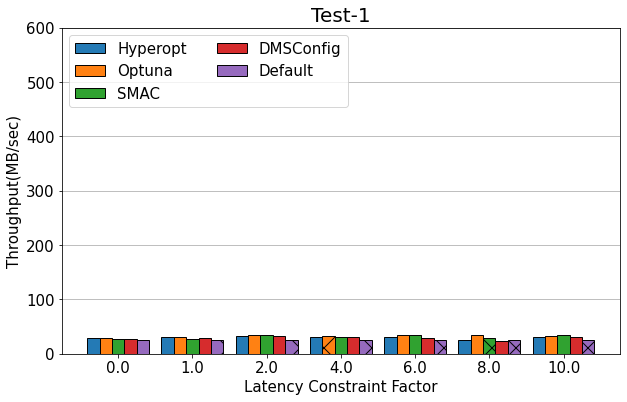

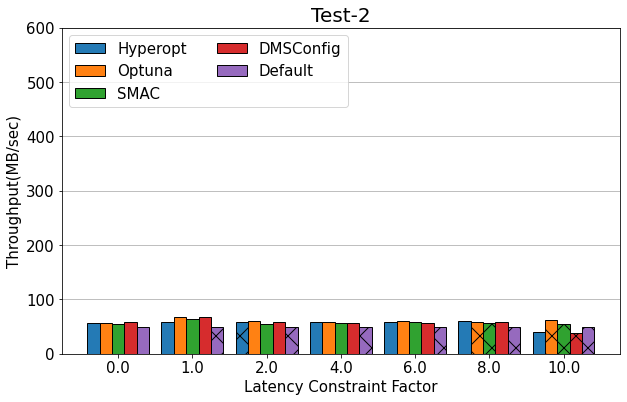

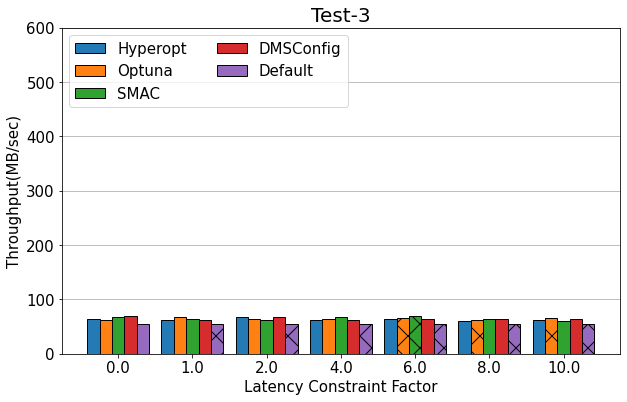

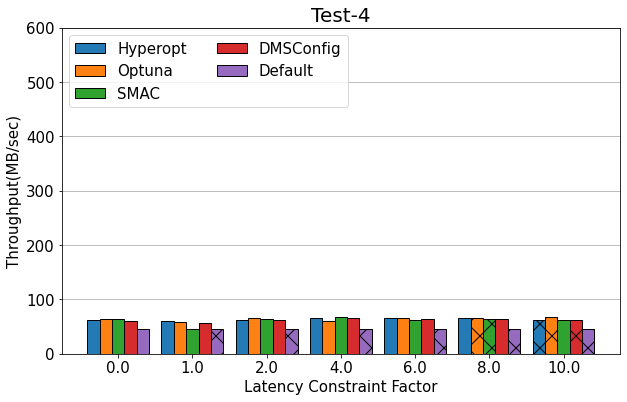

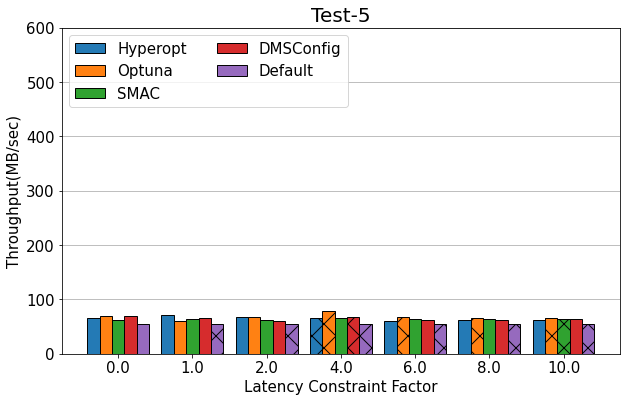

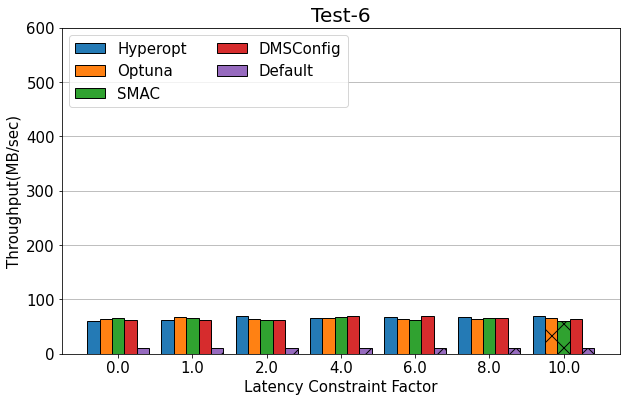

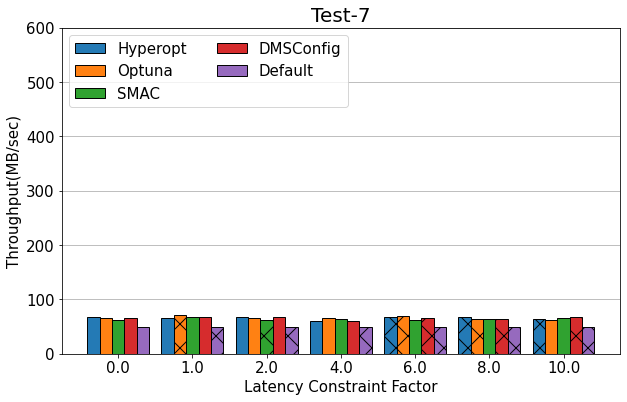

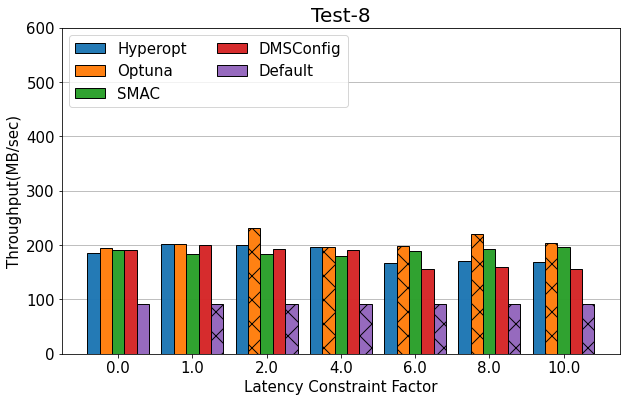

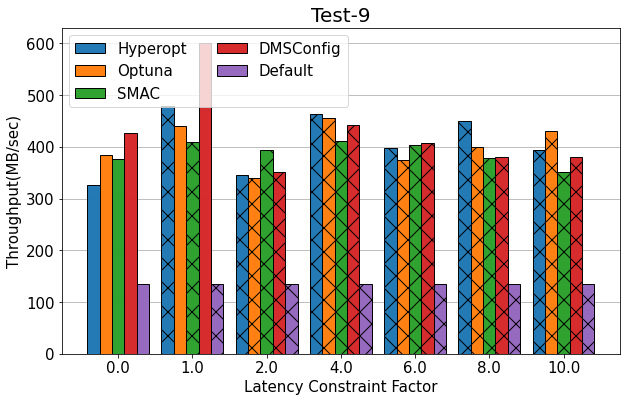

In [27]:
# process summary.csv
from matplotlib import pyplot as plt

all_records = []
# patterns = ('/','//','-', '+', 'x', '\\', '\\\\', '*', 'o', 'O', '.')
patterns = ('/', 'o', 'x', '.')
plt.rc('axes', axisbelow=True)

violations = {}
for alg in algs:
    violations.update({alg.split('/')[1]: []})

labels = ['Hyperopt', 'Optuna', 'SMAC', 'DMSConfig', 'Default']
for exp in exps:
    x = np.arange(7)
    plt.figure(figsize=(10,6))
    # try:
    for i, alg in enumerate(all_algs):
        total_width, n = 1, 6
        bar_width = total_width / n  #设置柱状图的宽度
        rlt = perf_summary[(perf_summary['exp'] == exp) & (perf_summary['alg'] == alg.split('/')[1])]
        tick_label = rlt['latency_bound_factor'].tolist()
        thrs = np.array(rlt['throughput'].tolist())
        lat_check = rlt['latency'] <= rlt['latency_bound']
        
        hatch = []
        for lc in lat_check:
            # if lc or 'default' in alg:
            if lc:
                hatch.append(None)
                violations[alg.split('/')[1]].append(0)
            else:
                hatch.append(r'x')
                violations[alg.split('/')[1]].append(1)

        bars = plt.bar(x+i*(bar_width), thrs, bar_width, label=labels[i], alpha=0.98, edgecolor='black')
        for i, bar in enumerate(bars):
            bar.set_hatch(hatch[i])

        plt.title('Test-%d' % (int(exp.split('-')[1])+1), fontsize=20)
        plt.grid(axis='y',zorder=0)
        plt.xlabel('Latency Constraint Factor', fontsize=15)
        plt.ylabel('Throughput(MB/sec)', fontsize=15)
    
    # plt.plot(x + 1.5 * bar_width, def_perf[def_perf['exp'] == exp]['throughput'].tolist()*5, color='black')
    plt.legend(ncol=2, loc='upper left', prop={'size': 15})  #显示图例，即label
    plt.xticks(x + 2 * bar_width,tick_label, fontsize=15)  #显示x坐标轴的标签,即tick_label,调整位置，使其落在两个直方图中间位置    
    plt.yticks(range(0, 700, 100), fontsize=15)
plt.show()

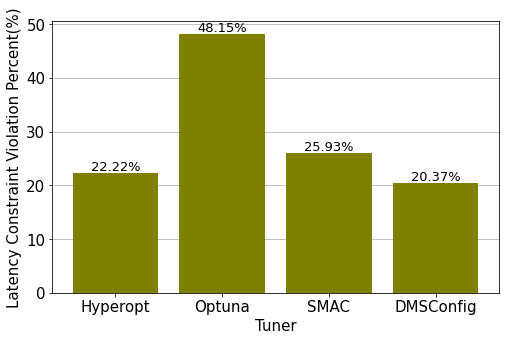

In [24]:
count = violations.copy()
for x in violations:
    count[x] = 100 * sum(violations[x]) / (len(violations[x])-9) # remove the lb=0

del count['default']
y = list(count.values())
xticks = labels
plt.figure(figsize=(8,5))
bar_plot = plt.bar(range(4), y, color='olive')
def autolabel(rects, pos, texts, rotate=True, va='bottom'):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        if rotate:
            rotation=90
        else:
            rotation=0
        plt.text(rect.get_x() + rect.get_width()/2., pos*height,
                '%.2f' % texts[idx] + '%',
                ha='center', va=va, rotation=rotation, fontsize=13)

bar_label = y
autolabel(bars, 1, bar_label, False)
plt.xticks(range(4), xticks, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Tuner', fontsize=15)
plt.ylabel('Latency Constraint Violation Percent(%)', fontsize=15)
plt.grid(axis='y')
plt.show()

In [25]:
# compare DMSConfig with default
dmsconfig_perf = perf_summary[perf_summary['alg'] == 'dmsconfig']
def_perf = perf_summary[perf_summary['alg'] == 'default']
cmp_def = pd.DataFrame([])
cmp_def['LB Factor'] = lat_bounds

for exp in exps:
    tmp = []
    for lb in lat_bounds:
        dms_thr = int(dmsconfig_perf[(dmsconfig_perf['exp'] == exp) & (dmsconfig_perf['latency_bound_factor'] == lb)]['throughput'])
        def_thr = int(def_perf[(def_perf['exp'] == exp) & (def_perf['latency_bound_factor'] == lb)]['throughput'])
        imp = int(100 * (dms_thr - def_thr) / def_thr)
        tmp.append(imp)
    cmp_def['Test-%d' % (int(exp.split('-')[1])+1)] = tmp
cmp_def = pd.DataFrame(cmp_def)
cmp_def.to_csv('dmsconfig_vs_default.csv', index=None)

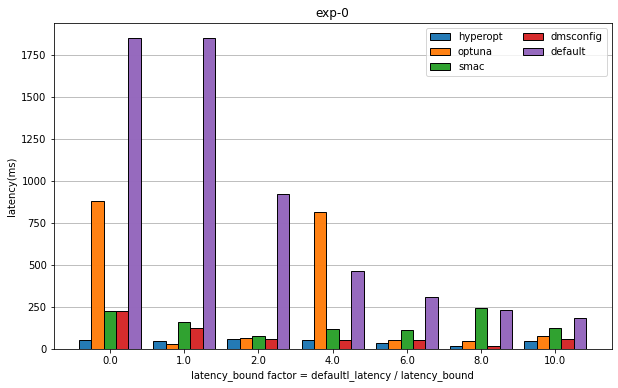

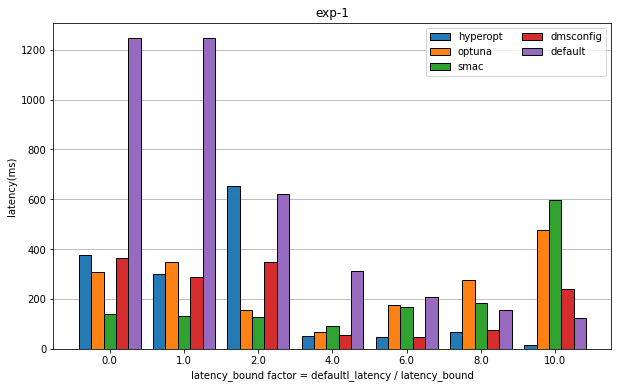

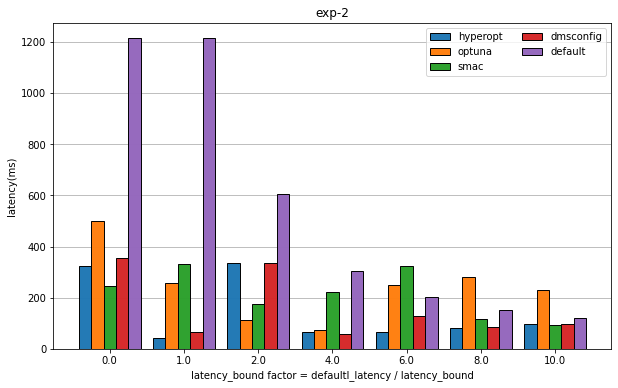

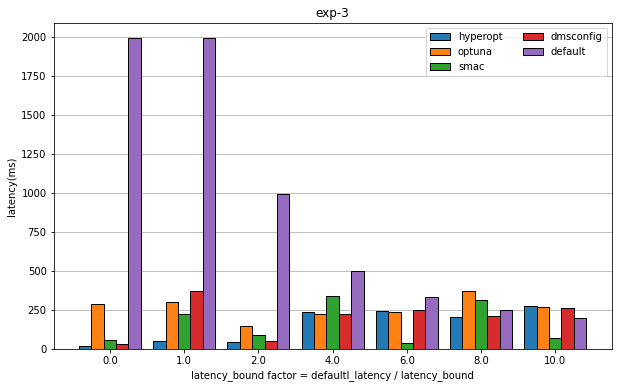

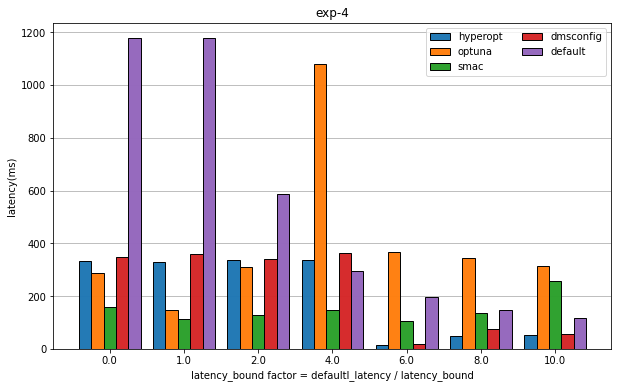

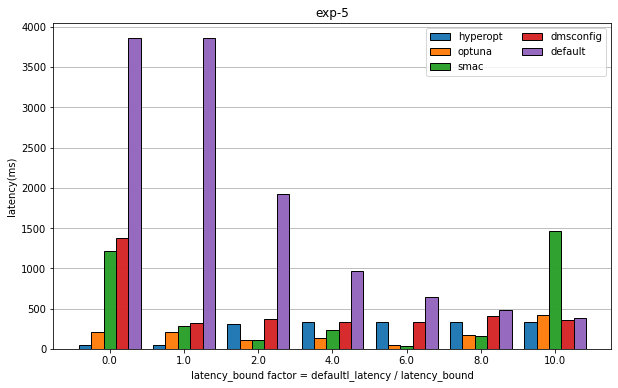

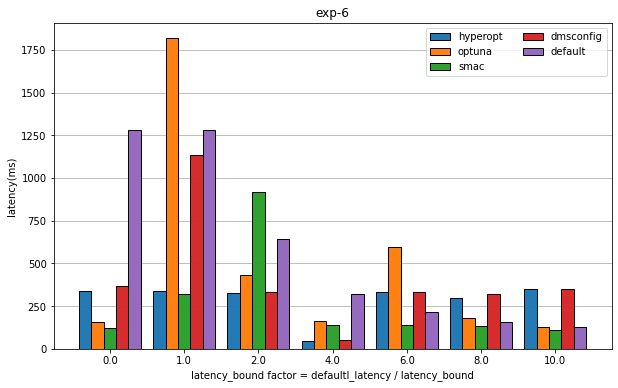

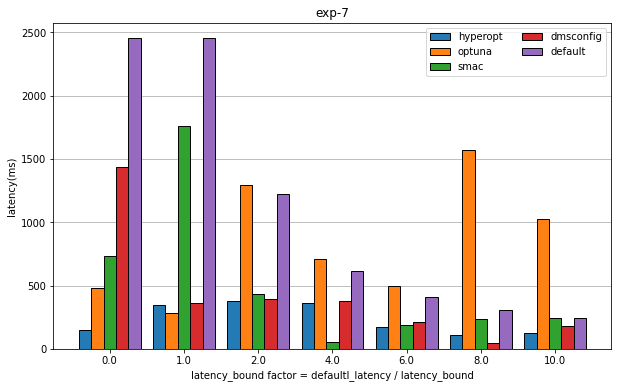

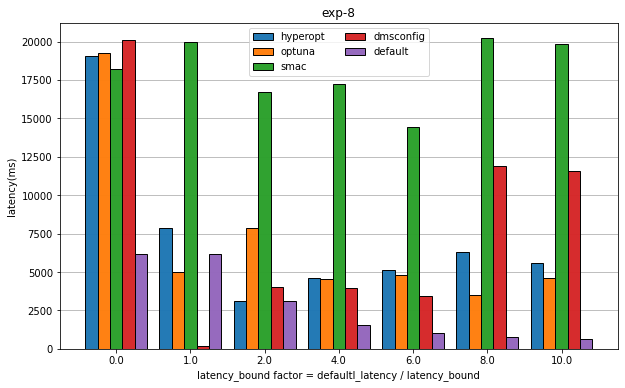

In [26]:
# process summary.csv
from matplotlib import pyplot as plt

all_records = []
# patterns = ('/','//','-', '+', 'x', '\\', '\\\\', '*', 'o', 'O', '.')
patterns = ('/', 'o', 'x', '.')
plt.rc('axes', axisbelow=True)
for j, exp in enumerate(exps):
    x = np.arange(7)
    plt.figure(figsize=(10,6))
    for i, alg in enumerate(all_algs):
        total_width, n = 1, 6
        bar_width = total_width / n  #设置柱状图的宽度
        rlt = perf_summary[(perf_summary['exp'] == exp) & (perf_summary['alg'] == alg.split('/')[1])]
        tick_label = rlt['latency_bound_factor'].tolist()
        if 'default' in alg:
            lats = []
            for k in range(len(lat_bounds)):
                if k==0:
                    lats.append(def_results[def_results['exp'] == exp]['latency'].tolist()[0])
                else:
                    lats.append(def_results[def_results['exp'] == exp]['latency'].tolist()[0] / (lat_bounds[k]))
        else:  
            lats = rlt['latency'].tolist()

        # lat_check = rlt['latency'] <= rlt['latency_bound']
        # for j, al in enumerate(lat_check):
        #     if not al:
        #         thrs[j] = -thrs[j]

        # bound = [int(rlt['latency_bound'][j]) for b in range(5)]
        # plt.plot(range(5), bound)
        plt.bar(x+i*(bar_width), lats, bar_width, label=alg.split('/')[1], alpha=0.98, edgecolor='black')
        # plt.bar(x+i*(bar_width), thrs, bar_width, label='alg=%s' % alg.split('/')[1], hatch=patterns[i], color='white', edgecolor='black',)
        plt.title(exp)
        plt.grid(axis='y',zorder=0)
        plt.xlabel('latency_bound factor = defaultl_latency / latency_bound')
        plt.ylabel('latency(ms)')
    plt.legend(ncol=2)  #显示图例，即label
    plt.xticks(x + 2 * bar_width,tick_label)  #显示x坐标轴的标签,即tick_label,调整位置，使其落在两个直方图中间位置    

plt.show()